In [1]:
import torch
import numpy as np
import os
from Modules.TreeLearn.TreeLearn import TreeLearn

In [2]:
cwd = os.getcwd()
modelPath = os.path.join( os.path.dirname(cwd), 'ModelSaves', 'TreeLearn', 'TreeLearn_U3_V0.02_N0.05.pt' )

# spatial_shape = [ 
#         np.round( 30/0.1 ).astype(int), 
#         np.round( 30/0.1 ).astype(int), 
#         np.round( 50/0.1 ).astype(int) 
#     ]

model = TreeLearn(dim_feat=1, use_coords=True, use_feats=False, num_blocks=3, voxel_size=0.02, spatial_shape=None).cuda()
model.load_state_dict(torch.load( modelPath, weights_only=True ))
model.eval()

In [3]:
data = np.load( os.path.join(os.path.dirname(cwd), 'data', 'labeled', 'cloud', '32_2_labeled.npy') )
points = torch.from_numpy( data[:, :3] ).float()
# feats = torch.zeros(len(points)).float()
feats = torch.from_numpy(data[:, 7]).float().unsqueeze(1)
batch_ids = torch.zeros(len(points), dtype=torch.long)
cyl_ids = data[:,6]

batch = {
    "coords": points,
    "feats": feats,
    "batch_ids": batch_ids,
    "batch_size": 1,  # Only one tree
}

with torch.no_grad():
    output = model.forward(batch, return_loss=False)

offset_predictions = output["offset_predictions"].cpu().numpy()  # Shape: (N, 3)
points = points.cpu().numpy()  # Convert to NumPy for plotting

[20. 21. 22.]


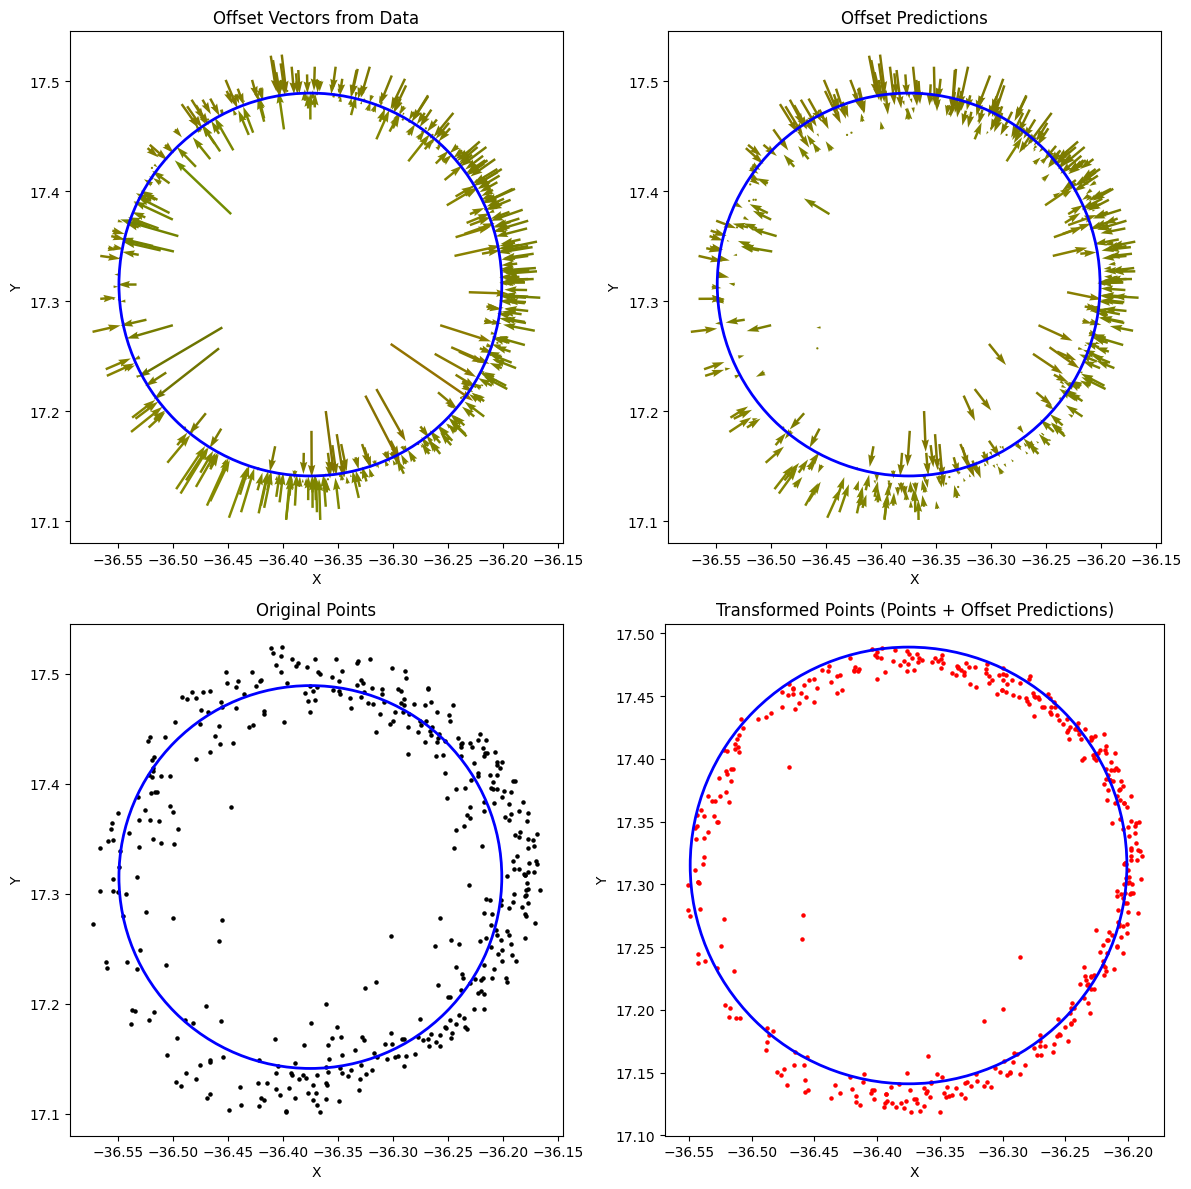

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import Normalize
import numpy as np

# --- Select a slice based on Z-values ---
z_min, z_max = 9.95, 10.05  # Define slice range
# z_min, z_max = 10.95, 11.05  # Define slice range
mask = (points[:, 2] >= z_min) & (points[:, 2] <= z_max)
points_slice = points[mask]
offset_slice = offset_predictions[mask]
offset_data = data[:, 3:6][mask]  # Offsets from data
print(np.unique(cyl_ids[mask]))

# Normalize offsets for RGB colors
norm = Normalize(vmin=-0.5, vmax=0.5)
colors_pred = np.stack([
    norm(offset_slice[:, 0]),  # X -> Red
    norm(offset_slice[:, 1]),  # Y -> Green
    np.zeros(len(offset_slice))  # Z -> No color (Blue=0)
], axis=1)

colors_data = np.stack([
    norm(offset_data[:, 0]),  # X -> Red
    norm(offset_data[:, 1]),  # Y -> Green
    np.zeros(len(offset_data))  # Z -> No color (Blue=0)
], axis=1)

# Points after applying offset
points_transformed = points_slice + offset_slice

# --- Create the figure with 2x2 subplots ---
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Top Left: Offset Vectors from Data
axs[0, 0].quiver(
    points_slice[:, 0], points_slice[:, 1],
    offset_data[:, 0], offset_data[:, 1],
    color=colors_data, angles='xy', scale_units='xy', scale=1, width=0.005
)
axs[0, 0].set_title("Offset Vectors from Data")

# Top Right: Offset Predictions
axs[0, 1].quiver(
    points_slice[:, 0], points_slice[:, 1],
    offset_slice[:, 0], offset_slice[:, 1],
    color=colors_pred, angles='xy', scale_units='xy', scale=1, width=0.005
)
axs[0, 1].set_title("Offset Predictions")

# Bottom Left: Scatter Plot of Original Points
axs[1, 0].scatter(points_slice[:, 0], points_slice[:, 1], c='black', s=5)
axs[1, 0].set_title("Original Points")

# Bottom Right: Scatter Plot of Transformed Points (Points + Offsets)
axs[1, 1].scatter(points_transformed[:, 0], points_transformed[:, 1], c='red', s=5)
axs[1, 1].set_title("Transformed Points (Points + Offset Predictions)")

# Add a circle centered at (-36.375, 17.315) with radius 0.174 to all subplots
for ax in axs.flatten():
    circle = Circle((-36.375, 17.315), 0.174, color='blue', fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

[  73.   74.   75.   76.   77. 5992. 5993. 5994. 6049. 6050. 6184. 6185.
 6186. 6187.]


C:\Users\Robin\AppData\Local\Temp\ipykernel_2172\1598844228.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20", len(unique_cyl_ids))  # Use a colormap with more distinct colors


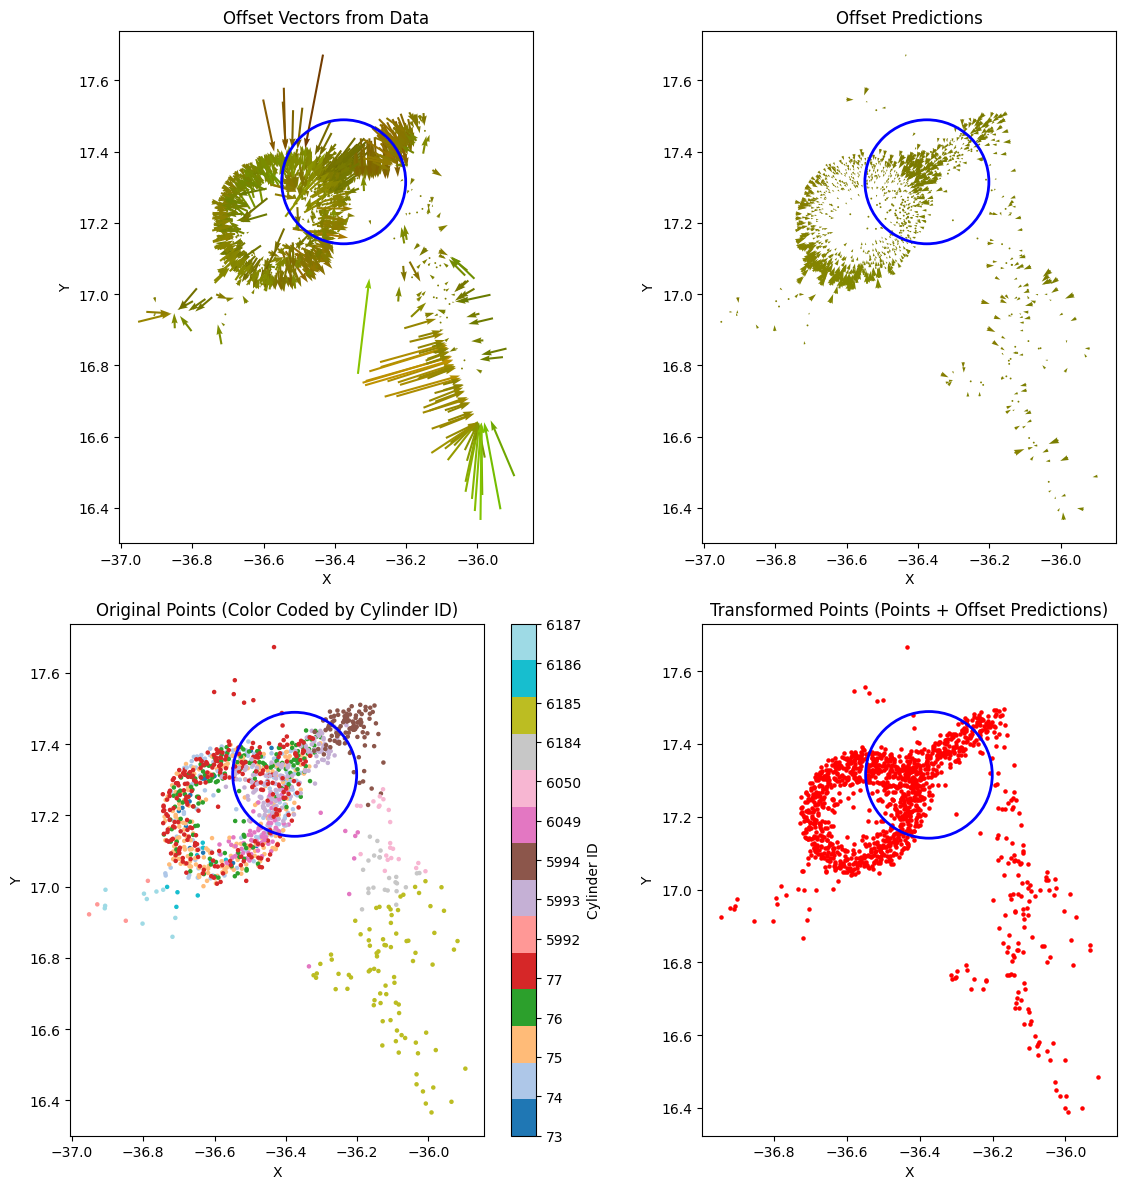

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap, ScalarMappable
import numpy as np

# --- Select a slice based on Z-values ---
z_min, z_max = 19.5, 20  # Define slice range
# z_min, z_max = 10.95, 11.05  # Define slice range
mask = (points[:, 2] >= z_min) & (points[:, 2] <= z_max)
points_slice = points[mask]
offset_slice = offset_predictions[mask]
offset_data = data[:, 3:6][mask]  # Offsets from data
cyl_ids_slice = cyl_ids[mask]
print(np.unique(cyl_ids_slice))

# Normalize offsets for RGB colors
norm = Normalize(vmin=-0.5, vmax=0.5)
colors_pred = np.stack([
    norm(offset_slice[:, 0]),  # X -> Red
    norm(offset_slice[:, 1]),  # Y -> Green
    np.zeros(len(offset_slice))  # Z -> No color (Blue=0)
], axis=1)

colors_data = np.stack([
    norm(offset_data[:, 0]),  # X -> Red
    norm(offset_data[:, 1]),  # Y -> Green
    np.zeros(len(offset_data))  # Z -> No color (Blue=0)
], axis=1)

# Points after applying offset
points_transformed = points_slice + offset_slice

# Create a colormap for cylinder IDs
unique_cyl_ids = np.unique(cyl_ids_slice)
cmap = get_cmap("tab20", len(unique_cyl_ids))  # Use a colormap with more distinct colors

# Normalize cylinder IDs (as categorical)
norm_cyl = Normalize(vmin=0, vmax=len(unique_cyl_ids) - 1)
cyl_ids_categorical = np.digitize(cyl_ids_slice, unique_cyl_ids) - 1  # Map cyl_ids to indices
colors_cyl = cmap(norm_cyl(cyl_ids_categorical))

# --- Create the figure with 2x2 subplots ---
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Top Left: Offset Vectors from Data
axs[0, 0].quiver(
    points_slice[:, 0], points_slice[:, 1],
    offset_data[:, 0], offset_data[:, 1],
    color=colors_data, angles='xy', scale_units='xy', scale=1, width=0.005
)
axs[0, 0].set_title("Offset Vectors from Data")

# Top Right: Offset Predictions
axs[0, 1].quiver(
    points_slice[:, 0], points_slice[:, 1],
    offset_slice[:, 0], offset_slice[:, 1],
    color=colors_pred, angles='xy', scale_units='xy', scale=1, width=0.005
)
axs[0, 1].set_title("Offset Predictions")

# Bottom Left: Scatter Plot of Original Points (Color-coded by Cylinder ID)
sc = axs[1, 0].scatter(points_slice[:, 0], points_slice[:, 1], c=colors_cyl, s=5)
axs[1, 0].set_title("Original Points (Color Coded by Cylinder ID)")

# Create and add a colorbar for cylinder IDs
sm = ScalarMappable(norm=norm_cyl, cmap=cmap)
cbar = plt.colorbar(sm, ax=axs[1, 0])
cbar.set_label("Cylinder ID")
cbar.set_ticks(np.arange(len(unique_cyl_ids)))
cbar.set_ticklabels(unique_cyl_ids.astype(int))  # Ensure proper integer labels

# Bottom Right: Scatter Plot of Transformed Points (Points + Offsets)
axs[1, 1].scatter(points_transformed[:, 0], points_transformed[:, 1], c='red', s=5)
axs[1, 1].set_title("Transformed Points (Points + Offset Predictions)")

# Add a circle centered at (-36.375, 17.315) with radius 0.174 to all subplots
for ax in axs.flatten():
    circle = Circle((-36.375, 17.315), 0.174, color='blue', fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()
